### EDA: Trực quan hóa và phân phối điểm theo môn, tổ hợp và năm

In [46]:
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
import numpy as np

In [47]:
import sys
import os

# 1. Lấy đường dẫn của thư mục 'Notebook'
current_dir = os.getcwd() 

# 2. Lấy đường dẫn của thư mục Project_Root (Thư mục cha của 'Notebook' và 'Module')
# Đây là thư mục Project_Root/
project_root_dir = os.path.dirname(current_dir)

# 3. Thêm Project_Root vào sys.path
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)
    
print(f"Đã thêm đường dẫn gốc: {project_root_dir}")

# Lệnh import này sẽ hoạt động sau khi thêm Project_Root vào sys.path
from Module.Load_Data import DataLoader, CleanDataLoader
from Module.Processor_Data import DataProcessor
from Module.Analysis import Analysis
from Module.ANOVA_ttest import ANOVA_ttest

Đã thêm đường dẫn gốc: c:\Users\Admin\OneDrive\Máy tính\Code\Project Python for Data\PythonProject


## Chọn môn học:

In [48]:
# Xây dựng Map chọn môn học
subject_map = {
    1: "toan",
    2: "ngu_van",
    3: "vat_li",
    4: "hoa_hoc",
    5: "sinh_hoc",
    6: "tin_hoc",
    7: "cn_cong_nghiep",
    8: "cn_nong_nghiep",
    9: "lich_su",
    10: "dia_li",
    11: "gdcd",
    12: "ngoai_ngu",
    13: "ma_ngoai_ngu"
}

print("=== Danh sách môn học ===")
for k, v in subject_map.items():
    print(f"{k}: {v}")

choice = int(input("\nNhập số môn bạn muốn chọn: "))

if choice in subject_map:
    print("Bạn đã chọn:", subject_map[choice])
else:
    print("❌ Không hợp lệ")


=== Danh sách môn học ===
1: toan
2: ngu_van
3: vat_li
4: hoa_hoc
5: sinh_hoc
6: tin_hoc
7: cn_cong_nghiep
8: cn_nong_nghiep
9: lich_su
10: dia_li
11: gdcd
12: ngoai_ngu
13: ma_ngoai_ngu


Bạn đã chọn: ngu_van


# Tải Dữ liệu theo Môn Học

In [49]:
# Load cleaned data: 
clean_data = CleanDataLoader() 

# Chọn môn học dựa trên lựa chọn của người dùng
ChoiceSubj = subject_map[choice] 

# Lấy dữ liệu phân phối điểm của môn học đã chọn
ChoiceSubj_df = clean_data.get_subject_data(subject=ChoiceSubj, kind="distribution")
ChoiceSubj_analyst = clean_data.get_subject_data(subject=ChoiceSubj, kind="analysis")

In [50]:
print(ChoiceSubj_df.head() ,"\n")
print(ChoiceSubj_analyst.head())

   nam_hoc  mon_hoc  diem  so_hoc_sinh
0     2023  ngu_van  0.00           24
1     2023  ngu_van  0.25            8
2     2023  ngu_van  0.50           19
3     2023  ngu_van  0.75           29
4     2023  ngu_van  1.00           12 

   nam_hoc      mean  median  mode       std  min    max
0     2023  6.858194    7.00   7.0  1.326471  0.0  10.00
1     2024  7.231146    7.50   8.0  1.330057  0.0  10.00
2     2025  6.990479    7.25   7.5  1.291049  0.0   9.75


# Xây dựng hàm trực quan theo môn học:

## 🔹 Khung 1 – Histogram theo năm

In [51]:
def visualize_subject_hist(subject_code: str, subject_name: str):
    """
    Vẽ histogram theo KHOẢNG ĐIỂM cho một môn học, gồm 2 phần:

    1) Histogram từng năm (mỗi năm 1 ô riêng) theo khoảng:
       [0,0.5], (0.5,1], (1,1.5], ..., (9.5,10]
       -> Thể hiện bằng barplot (sns.barplot) trên trục x là các khoảng điểm.

    2) Một histogram GỘP CÁC NĂM trong cùng một khung (ô thứ 4),
       dùng seaborn.histplot, overlay các năm, vẫn chia khoảng như trên.
    """
    print(f"📌 [Histogram theo khoảng] Môn: {subject_name} ({subject_code})")

    # 1. Lấy dữ liệu phân phối (distribution) của môn
    df_agg = clean_data.get_subject_data(subject=subject_code, kind="distribution")

    if df_agg.empty:
        print(f"⚠ Không có dữ liệu cho môn {subject_name}")
        return

    # 2. Định nghĩa chung: edges & labels cho KHOẢNG ĐIỂM
    #    edges: [-1e-6, 0.5, 1, 1.5, ..., 10]
    edges = np.concatenate((
        np.array([-1e-6, 0.5]),   # ~ [0,0.5]
        np.arange(1, 10.5, 0.5)   # 1, 1.5, 2, ..., 10
    ))

    # edges để HIỂN THỊ label (không để -1e-6 trên trục)
    display_edges = edges.copy()
    display_edges[0] = 0.0

    # tạo nhãn cho từng khoảng: [0,0.5], (0.5,1], ...
    labels = []
    labels.append(f"[{display_edges[0]},{display_edges[1]}]")   # bin đầu

    for i in range(1, len(display_edges) - 1):
        labels.append(f"({display_edges[i]},{display_edges[i+1]}]")

    # tâm mỗi bin để dùng cho tick / hist gộp
    centers = (edges[:-1] + edges[1:]) / 2

    # 3. Tạo figure 2x2
    fig, axes = plt.subplots(2, 2, figsize=(16, 8))
    axes = axes.ravel()  # flatten: axes[0], axes[1], axes[2], axes[3]

    # 4. Hàm con: vẽ barplot theo khoảng cho 1 năm lên 1 axis
    def _plot_single_year(points: np.ndarray, year: int, ax):
        """
        Vẽ barplot theo khoảng cho 1 năm, dùng sns.barplot,
        trục x là các khoảng điểm, trục y là số học sinh.
        """
        # Gán mỗi điểm vào 1 khoảng (bin)
        bins_cat = pd.cut(
            points,
            bins=edges,
            labels=labels,
            include_lowest=True,
            right=True
        )

        # Đếm số lượng theo từng khoảng
        bin_counts = (
            pd.DataFrame({"bin": bins_cat})
            .groupby("bin", observed=False)
            .size()
            .reindex(labels, fill_value=0)   # đảm bảo đủ mọi khoảng, kể cả count=0
            .reset_index(name="count")
        )

        sns.barplot(
            data=bin_counts,
            x="bin",
            y="count",
            order=labels,
            color="C0",
            edgecolor="black",
            ax=ax,
        )

        ax.set_title(f"Phổ điểm {subject_name} năm {year}", fontsize=12)
        ax.set_xlabel("Khoảng điểm", fontsize=11)
        ax.set_ylabel("Số học sinh", fontsize=11)
        ax.tick_params(axis="x", rotation=90)  # chỉ xoay label, không set_ticklabels
        ax.grid(axis="y", linestyle="--", alpha=0.5)

        # ---- Đặt y-limit & số trên đầu cột ----
        max_count = bin_counts["count"].max()
        ax.set_ylim(0, max_count * 1.10 if max_count > 0 else 1)

        for p in ax.patches:
            height = p.get_height()
            if height == 0:
                continue
            ax.annotate(
                text=str(int(height)),
                xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(0, 3),                  # lệch lên 3 điểm ảnh
                textcoords="offset points",
                ha="center",
                va="bottom",
                fontsize=8,
                rotation=90,
            )

    # 5. Vẽ barplot THEO TỪNG NĂM (tối đa 3 ô đầu)
    years = sorted(df_agg["nam_hoc"].unique())
    all_raw = []   # để gom lại cho phần hist gộp

    for idx, year in enumerate(years[:3]):
        df_year = df_agg[df_agg["nam_hoc"] == year]

        # tái tạo điểm thô của năm đó
        points_year = np.repeat(
            df_year["diem"].values,
            df_year["so_hoc_sinh"].values.astype(int)
        )
        all_raw.append(pd.DataFrame({"nam_hoc": year, "diem": points_year}))

        # vẽ barplot theo khoảng cho riêng năm này lên axes[idx]
        _plot_single_year(points_year, year, axes[idx])

    # Nếu số năm < 3 → tắt những ô dư (0,1,2 chỉ dùng theo số year)
    for idx in range(len(years), 3):
        axes[idx].axis("off")

    # 6. VẼ HISTOGRAM GỘP CÁC NĂM TRONG Ô THỨ 4
    full_df = pd.concat(all_raw, ignore_index=True)

    ax4 = axes[3]

    for year in years:
        sns.histplot(
            data=full_df[full_df["nam_hoc"] == year],
            x="diem",
            bins=edges,          # dùng khoảng chia custom
            kde=False,
            stat="count",
            element="bars",
            alpha=0.4,
            label=str(year),
            ax=ax4,
        )

    ax4.set_title(
        f"Histogram gộp các năm - môn {subject_name}",
        fontsize=12
    )
    ax4.set_xlabel("Khoảng điểm", fontsize=11)
    ax4.set_ylabel("Số lượng thí sinh", fontsize=11)
    ax4.grid(axis="y", linestyle="--", alpha=0.5)
    ax4.legend(title="Năm", fontsize=9, title_fontsize=9)

    # Gắn nhãn khoảng điểm cho trục x (dùng centers + labels)
    ax4.set_xticks(centers)
    ax4.set_xticklabels(labels, rotation=90)

    plt.tight_layout()
    plt.show()


# 🔹 Khung 2 – KDE chồng các năm

In [52]:
def visualize_subject_kde(subject_code: str, subject_name: str):
    """
    Vẽ đường KDE (mật độ) điểm cho một môn học cụ thể.

    - Dùng dữ liệu phân phối (kind="distribution").
    - Tái tạo dữ liệu thô như ở Histogram.
    - Chia figure 2x2:
        + 3 ô đầu: KDE từng năm (mỗi năm 1 subplot).
        + Ô thứ 4: KDE chồng các năm để so sánh phân phối điểm.
    """
    print(f"📌 [KDE] Đang xử lý môn: {subject_name} ({subject_code})")

    # 1. Lấy dữ liệu tần suất từ Analysis (bản distribution)
    df_agg = clean_data.get_subject_data(subject=subject_code, kind="distribution")

    if df_agg.empty:
        print(f"⚠ Không có dữ liệu cho môn {subject_name}")
        return

    # 2. Tái tạo dữ liệu thô từ tần suất
    raw = []
    years = sorted(df_agg["nam_hoc"].unique())

    for year in years:
        df_y = df_agg[df_agg["nam_hoc"] == year]
        scores = np.repeat(
            df_y["diem"].values,
            df_y["so_hoc_sinh"].values.astype(int)
        )
        raw.append(pd.DataFrame({"nam_hoc": year, "diem": scores}))

    full_df = pd.concat(raw, ignore_index=True)

    # 3. Tạo figure 2x2: 3 ô cho từng năm, 1 ô gộp 3 năm
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    axes = axes.ravel()  # flatten thành 1D: axes[0], axes[1], axes[2], axes[3]

    # -----------------------------
    # 3.1 KDE TỪNG NĂM (tối đa 3 năm)
    # -----------------------------
    for idx, year in enumerate(years[:3]):
        ax = axes[idx]
        data_year = full_df[full_df["nam_hoc"] == year]["diem"]

        sns.kdeplot(
            x=data_year,
            fill=False,
            linewidth=2,
            ax=ax,
        )

        ax.set_title(f"KDE điểm môn {subject_name} - năm {year}", fontsize=12)
        ax.set_xlabel("Điểm")
        ax.set_ylabel("Mật độ")
        ax.set_xlim(0, 10)
        ax.set_xticks(np.arange(0, 10.5, 1))
        ax.grid(axis="y", linestyle="--", alpha=0.5)

    # Nếu số năm < 3, tắt những ô dư (trừ ô thứ 4 để gộp)
    for idx in range(len(years), 3):
        axes[idx].axis("off")

    # -----------------------------
    # 3.2 KDE GỘP CÁC NĂM (subplot thứ 4)
    # -----------------------------
    ax4 = axes[3]

    sns.kdeplot(
        data=full_df,
        x="diem",
        hue="nam_hoc",
        common_norm=False,
        fill=False,
        linewidth=2,
        ax=ax4,
    )

    ax4.set_title(f"KDE gộp các năm - môn {subject_name}", fontsize=12)
    ax4.set_xlabel("Điểm")
    ax4.set_ylabel("Mật độ")
    ax4.set_xlim(0, 10)
    ax4.set_xticks(np.arange(0, 10.5, 1))
    ax4.grid(axis="y", linestyle="--", alpha=0.5)

    # Legend: chỉ tạo nếu thật sự có handles/labels → tránh UserWarning
    handles, labels = ax4.get_legend_handles_labels()
    if handles:
        ax4.legend(
            handles=handles,
            labels=labels,
            title="Năm",
            fontsize=9,
            title_fontsize=9
        )

    plt.tight_layout()
    plt.show()


# 🔹 Khung 3 – Boxplot + Bảng thống kê mô tả

In [53]:
def visualize_subject_boxplot_and_stats(subject_code: str, subject_name: str):
    """
    Vẽ Boxplot so sánh phân phối điểm theo năm
    và in ra bảng thống kê mean/median/std/%>=5/%>=8 cho môn học.

    - Dùng distribution để vẽ & tính %>=5, %>=8.
    - Dùng analysis để lấy các thống kê mean/median/std (min/max nếu cần).
    """
    print(f"📌 [Boxplot + Stats] Đang xử lý môn: {subject_name} ({subject_code})")

    # 1. Lấy dữ liệu tần suất từ Analysis (bản distribution)
    df_agg = clean_data.get_subject_data(subject=subject_code, kind="distribution")

    if df_agg.empty:
        print(f"⚠ Không có dữ liệu cho môn {subject_name}")
        return

    # 2. Tái tạo dữ liệu thô từ tần suất
    raw = []
    for year in sorted(df_agg["nam_hoc"].unique()):
        df_y = df_agg[df_agg["nam_hoc"] == year]
        scores = np.repeat(
            df_y["diem"].values,
            df_y["so_hoc_sinh"].values.astype(int)
        )
        raw.append(pd.DataFrame({"nam_hoc": year, "diem": scores}))

    full_df = pd.concat(raw, ignore_index=True)

    # 3. Lấy dữ liệu phân tích (analysis) – đã có sẵn mean/median/mode/std/min/max
    stats_raw = clean_data.get_subject_data(subject=subject_code, kind="analysis")

    # stats_raw hiện có dạng:
    # nam_hoc | mean | median | mode | std | min | max
    # → đưa nam_hoc lên làm index cho tiện tra cứu
    stats_df = stats_raw.set_index("nam_hoc").copy()

    # 4. Tính thêm tỷ lệ >=5 và >=8 dựa trên bảng distribution df_agg
    for year in stats_df.index:
        df_y = df_agg[df_agg["nam_hoc"] == year]
        total = df_y["so_hoc_sinh"].sum()
        ge5 = df_y[df_y["diem"] >= 5]["so_hoc_sinh"].sum()
        ge8 = df_y[df_y["diem"] >= 8]["so_hoc_sinh"].sum()

        stats_df.loc[year, "%>=5"] = round(ge5 / total * 100, 2) if total > 0 else 0
        stats_df.loc[year, "%>=8"] = round(ge8 / total * 100, 2) if total > 0 else 0

    # ----- BOXPLOT -----
    plt.figure(figsize=(10, 5))

    sns.boxplot(
        data=full_df,
        x="nam_hoc",
        y="diem",
        hue="nam_hoc",        # thêm hue → không bị warning
        dodge=False,          # tránh vẽ 2 box trùng
        palette="Set2",
        vert = True,
    )

    plt.title(f"Boxplot điểm môn {subject_name}", fontsize=14)
    plt.xlabel("Năm")
    plt.ylabel("Điểm")
    plt.grid(axis="y", linestyle="--", alpha=0.5)

    # Bỏ duplicate legend
    plt.legend().remove()
    plt.show()

    # ----- BẢNG THỐNG KÊ -----
    print("\n📊 Bảng thống kê mô tả:")
    display(stats_df[["mean", "median", "std", "%>=5", "%>=8"]])
    print("-" * 60)


# 🔹EDA Subject - All 

In [54]:
def visualize_subject_eda_all(subject_code: str, subject_name: str):
    """
    Chạy full EDA cho một môn học:
    - Histogram theo năm (bin = 0.25)
    - KDE chồng các năm
    - Boxplot so sánh phân phối theo năm + bảng thống kê mean/median/std/%>=5/%>=8.
    """
    print(f"================ EDA môn {subject_name} ({subject_code}) ================")

    # 1. Histogram
    visualize_subject_hist(subject_code, subject_name)

    # 2. KDE
    visualize_subject_kde(subject_code, subject_name)

    # 3. Boxplot + Stats
    visualize_subject_boxplot_and_stats(subject_code, subject_name)

    print(f"================ Hoàn thành EDA môn {subject_name} ================\n")


================ EDA môn ngu_van (ngu_van) ================
📌 [Histogram theo khoảng] Môn: ngu_van (ngu_van)


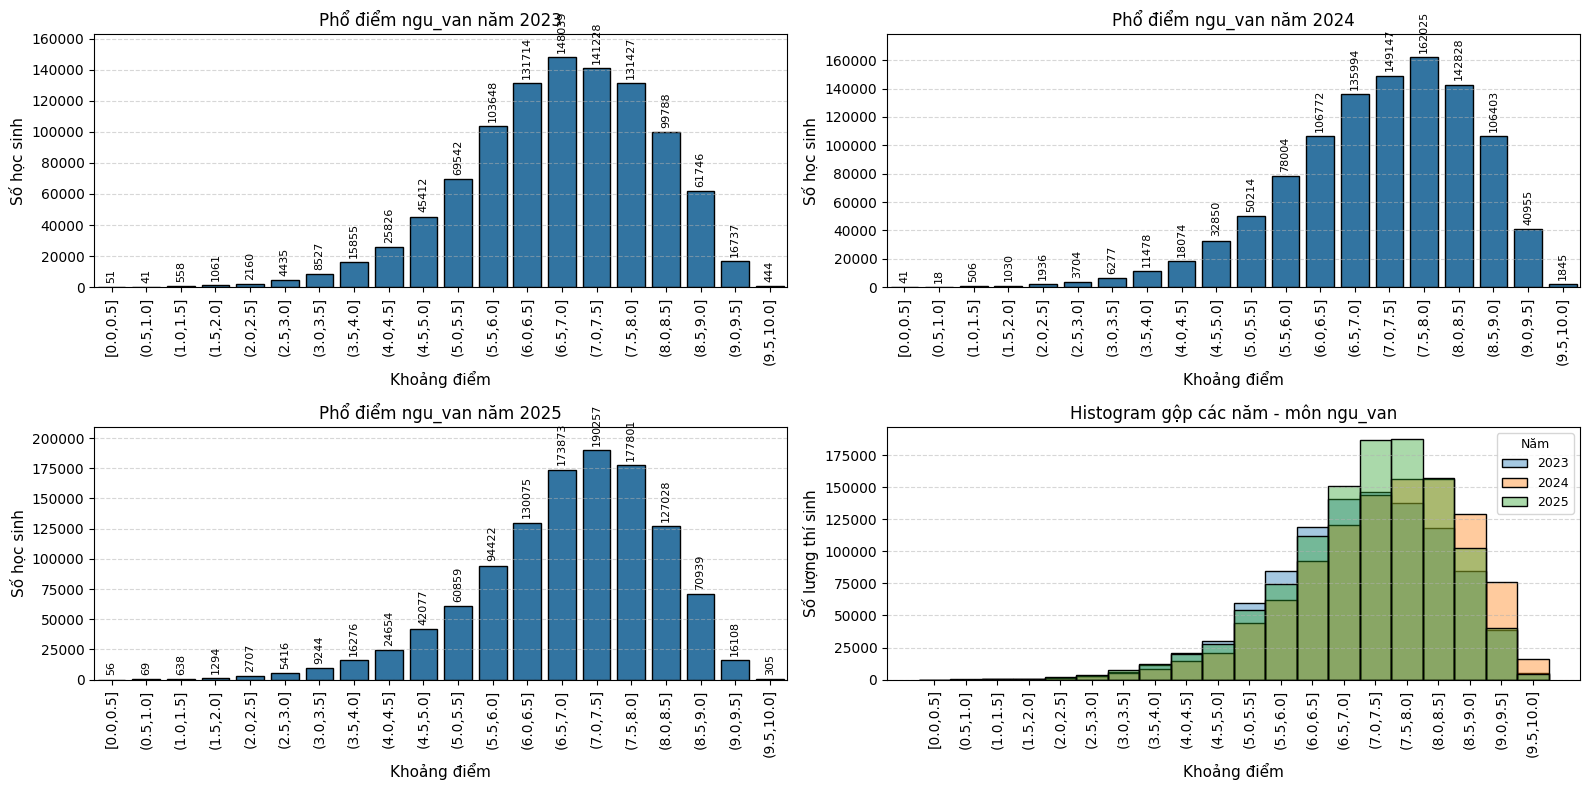

📌 [KDE] Đang xử lý môn: ngu_van (ngu_van)


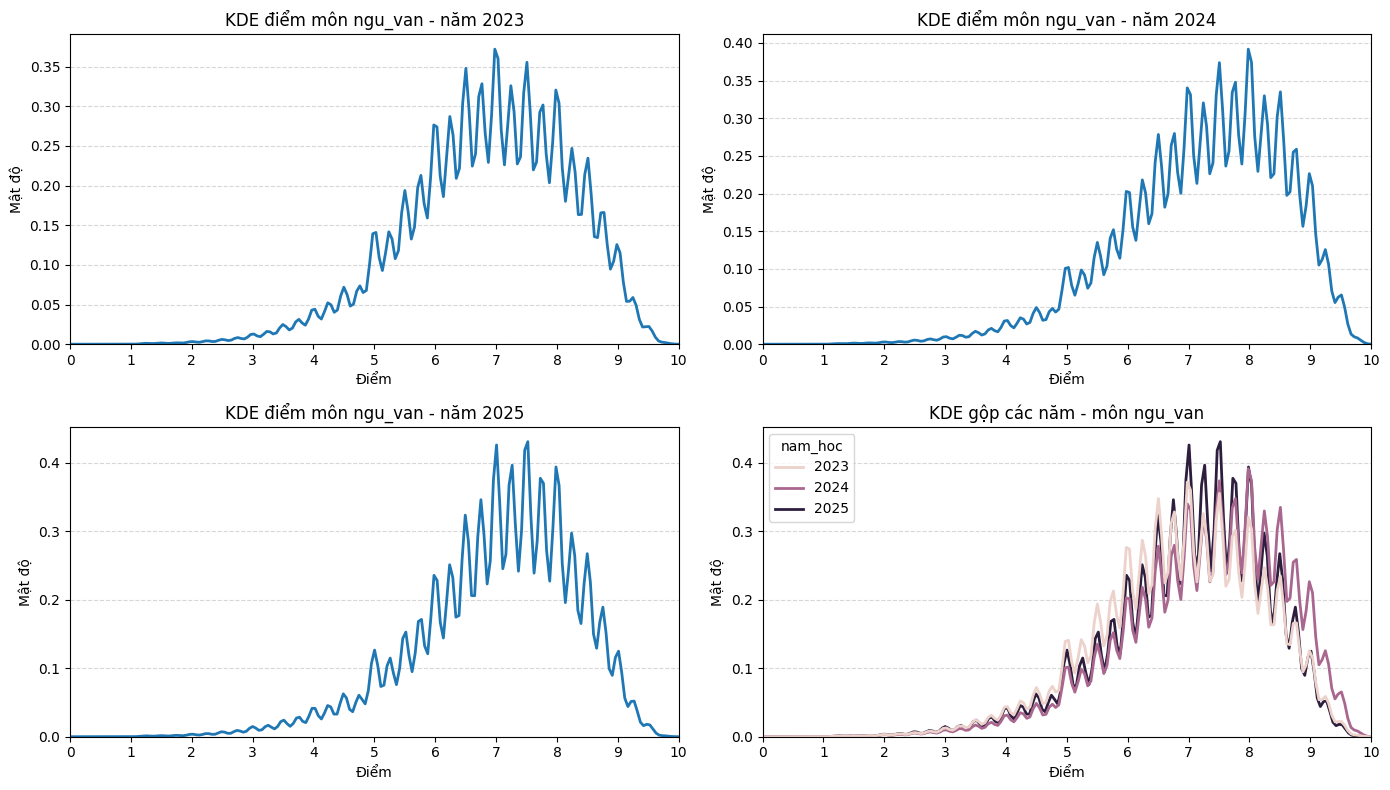

📌 [Boxplot + Stats] Đang xử lý môn: ngu_van (ngu_van)


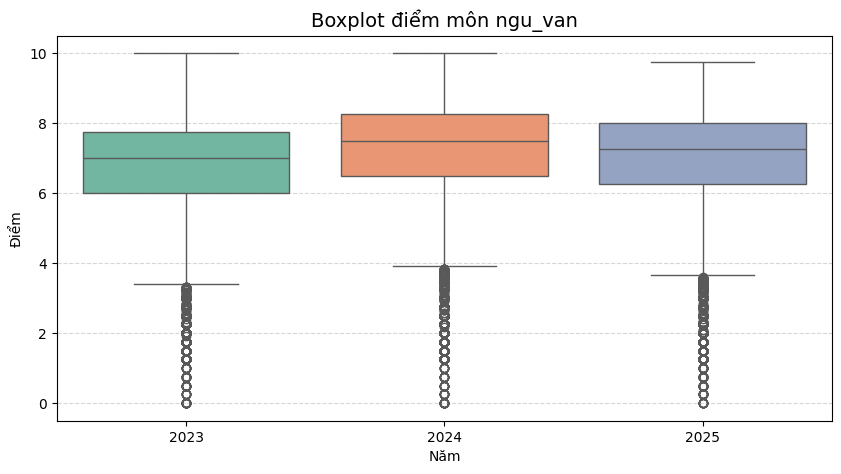


📊 Bảng thống kê mô tả:


,mean,median,std,%>=5,%>=8
nam_hoc,,,,,
2023,6.858194,7.00,1.326471,92.69,24.42
2024,7.231146,7.50,1.330057,94.93,35.99
2025,6.990479,7.25,1.291049,93.53,26.60


------------------------------------------------------------
================ Hoàn thành EDA môn ngu_van ================



In [55]:
# Chạy EDA cho môn đã chọn
visualize_subject_eda_all(ChoiceSubj, subject_map[choice])


# Kiểm định ANOVA & t-test

In [57]:
# 1. Tạo object kiểm định từ distribution của môn đã chọn
anova_ttest = ANOVA_ttest(
    ChoiceSubj_df,
    group_col="nam_hoc",   # nhóm theo năm
    score_col="diem"       # cột điểm dùng để kiểm định
)

# 2. T-test môn học giữa 2 năm
ttest_subj = anova_ttest.t_test_subject_two_years(
    subject=ChoiceSubj,    # ví dụ: "toan"
    year1=2024,
    year2=2025
)

print("\n📌 Kết quả kiểm định t-test giữa 2 năm 2024 và 2025:")
display(ttest_subj)

# 3. ANOVA môn học qua các năm
anova_subj = anova_ttest.anova_subject(subject=ChoiceSubj)

print("\n📌 Kết quả kiểm định ANOVA qua các năm:")
display(anova_subj)



📌 Kết quả kiểm định t-test giữa 2 năm 2024 và 2025:


{'subject': 'ngu_van',
 'year1': 2024,
 'year2': 2025,
 't_stat': 135.78331048917966,
 'p_value': 0.0,
 'one_tail': False,
 'alternative': 'less',
 'cohens_d': 0.18361742445739823,
 'effect_strength': 'Rất yếu',
 'interpretation': 'Có sự khác biệt.'}


📌 Kết quả kiểm định ANOVA qua các năm:


{'subject': 'ngu_van',
 'anova_f': 21398.381624100744,
 'anova_p': 0.0,
 'interpretation': 'Có khác biệt giữa các năm.'}

# Nhận xét: 

******

# Theo Khối

In [ ]:
# Cell 3: Phân tích xu hướng chọn khối thi (FIXED X-AXIS)

def visualize_block_trends(blocks=['A00', 'B00', 'C00', 'D01']):
    """
    Vẽ biểu đồ Stacked Area thể hiện tỷ lệ thí sinh chọn các khối.
   
    """
    
    print("--- Đang tổng hợp dữ liệu các khối thi... ---")

    df = processor.get_processed_data()

    # Map môn trong khối (chuẩn Bộ GD)
    block_map = {
        "A00": ["toan", "vat_li", "hoa_hoc"],
        "A01": ["toan", "vat_li", "ngoai_ngu"],
        "B00": ["toan", "hoa_hoc", "sinh_hoc"],
        "C00": ["ngu_van", "lich_su", "dia_li"],
        "D01": ["toan", "ngu_van", "ngoai_ngu"]
    }

    # Alias xử lý tên cột không đồng nhất
    alias = {
        "vat_li": ["vat_li", "ly"],
        "hoa_hoc": ["hoa_hoc", "hoa"],
        "sinh_hoc": ["sinh_hoc", "sinh"],
        "lich_su": ["lich_su", "su"],
        "dia_li": ["dia_li", "dia"],
        "ngu_van": ["ngu_van", "van"],
        "ngoai_ngu": ["ngoai_ngu", "anh"]
    }

    def find_real_col(mon):
        if mon not in alias:
            return mon
        for c in alias[mon]:
            if c in df.columns:
                return c
        return None

    # Tính số lượng thí sinh
    result = {}
    for block in blocks:
        if block not in block_map: continue

        subjects = []
        for subj in block_map[block]:
            real = find_real_col(subj)
            if real is not None:
                subjects.append(real)

        if len(subjects) < 3:
            print(f"⚠ Khối {block} thiếu môn -> bỏ qua")
            continue

        # Lấy thí sinh thi đủ 3 môn của khối
        df_block = df[["nam_hoc"] + subjects].dropna()
        count = df_block.groupby("nam_hoc").size()
        result[block] = count

    # Tạo DataFrame & Tính %
    df_trends = pd.DataFrame(result).fillna(0).astype(int)
    
    if df_trends.empty:
        print("⚠ Không có dữ liệu!")
        return

    # Sắp xếp index (năm) để đảm bảo đúng thứ tự
    df_trends = df_trends.sort_index()
    
    df_percent = df_trends.div(df_trends.sum(axis=1), axis=0) * 100

    # --- VẼ BIỂU ĐỒ ---
    plt.figure(figsize=(12, 7))
    
    # Vẽ Stackplot
    plt.stackplot(df_percent.index, df_percent.T.values, labels=df_percent.columns, alpha=0.85)
    
    plt.title("Xu hướng lựa chọn khối thi (Tỷ lệ %)", fontsize=16)
    plt.xlabel("Năm học", fontsize=12)
    plt.ylabel("Tỷ lệ (%)", fontsize=12)
    plt.legend(loc="upper left", title="Khối thi", bbox_to_anchor=(1, 1))
    
    # --- FIX LỖI TRỤC HOÀNH Ở ĐÂY ---
    # Chỉ lấy các năm có trong index và ép về kiểu int để hiển thị
    years = df_percent.index.astype(int).tolist()
    plt.xticks(years, [str(y) for y in years]) 
    
    # Giới hạn trục x cho gọn
    plt.xlim(min(years), max(years))
    plt.margins(0, 0) # Bỏ khoảng trắng thừa 2 bên
    
    plt.tight_layout()
    plt.show()

    print("\n📊 Bảng số lượng thí sinh chi tiết:")
    display(df_trends)

# --- CHẠY ---
visualize_block_trends(['A00', 'A01', 'B00', 'C00', 'D01'])


In [ ]:
# Cell 3: Phân tích xu hướng chọn khối thi (FIXED X-AXIS)

def visualize_block_trends(blocks=['A00', 'B00', 'C00', 'D01']):
    """
    Vẽ biểu đồ Stacked Area thể hiện tỷ lệ thí sinh chọn các khối.
   
    """
    
    print("--- Đang tổng hợp dữ liệu các khối thi... ---")

    df = processor.get_processed_data()

    # Map môn trong khối (chuẩn Bộ GD)
    block_map = {
        "A00": ["toan", "vat_li", "hoa_hoc"],
        "A01": ["toan", "vat_li", "ngoai_ngu"],
        "B00": ["toan", "hoa_hoc", "sinh_hoc"],
        "C00": ["ngu_van", "lich_su", "dia_li"],
        "D01": ["toan", "ngu_van", "ngoai_ngu"]
    }

    # Alias xử lý tên cột không đồng nhất
    alias = {
        "vat_li": ["vat_li", "ly"],
        "hoa_hoc": ["hoa_hoc", "hoa"],
        "sinh_hoc": ["sinh_hoc", "sinh"],
        "lich_su": ["lich_su", "su"],
        "dia_li": ["dia_li", "dia"],
        "ngu_van": ["ngu_van", "van"],
        "ngoai_ngu": ["ngoai_ngu", "anh"]
    }

    def find_real_col(mon):
        if mon not in alias:
            return mon
        for c in alias[mon]:
            if c in df.columns:
                return c
        return None

    # Tính số lượng thí sinh
    result = {}
    for block in blocks:
        if block not in block_map: continue

        subjects = []
        for subj in block_map[block]:
            real = find_real_col(subj)
            if real is not None:
                subjects.append(real)

        if len(subjects) < 3:
            print(f"⚠ Khối {block} thiếu môn -> bỏ qua")
            continue

        # Lấy thí sinh thi đủ 3 môn của khối
        df_block = df[["nam_hoc"] + subjects].dropna()
        count = df_block.groupby("nam_hoc").size()
        result[block] = count

    # Tạo DataFrame & Tính %
    df_trends = pd.DataFrame(result).fillna(0).astype(int)
    
    if df_trends.empty:
        print("⚠ Không có dữ liệu!")
        return

    # Sắp xếp index (năm) để đảm bảo đúng thứ tự
    df_trends = df_trends.sort_index()
    
    df_percent = df_trends.div(df_trends.sum(axis=1), axis=0) * 100

    # --- VẼ BIỂU ĐỒ ---
    plt.figure(figsize=(12, 7))
    
    # Vẽ Stackplot
    plt.stackplot(df_percent.index, df_percent.T.values, labels=df_percent.columns, alpha=0.85)
    
    plt.title("Xu hướng lựa chọn khối thi (Tỷ lệ %)", fontsize=16)
    plt.xlabel("Năm học", fontsize=12)
    plt.ylabel("Tỷ lệ (%)", fontsize=12)
    plt.legend(loc="upper left", title="Khối thi", bbox_to_anchor=(1, 1))
    
    # --- FIX LỖI TRỤC HOÀNH Ở ĐÂY ---
    # Chỉ lấy các năm có trong index và ép về kiểu int để hiển thị
    years = df_percent.index.astype(int).tolist()
    plt.xticks(years, [str(y) for y in years]) 
    
    # Giới hạn trục x cho gọn
    plt.xlim(min(years), max(years))
    plt.margins(0, 0) # Bỏ khoảng trắng thừa 2 bên
    
    plt.tight_layout()
    plt.show()

    print("\n📊 Bảng số lượng thí sinh chi tiết:")
    display(df_trends)

# --- CHẠY ---
visualize_block_trends(['A00', 'A01', 'B00', 'C00', 'D01'])


******

# Theo Năm 

In [ ]:
# Xử lý data qua từng năm